In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install fasttext

    !git clone https://github.com/MartinKirkegaardDK/KDS_MI.git

    if not has_changed_dir:
        os.chdir('KDS_MI')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

Running as a Colab notebook
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from drivers import (
    preprocessing,probe_confidence_intervals,
    steering, create_steering_vectors,
    steering_loss,
    distance_plots,
    create_average_activation_vectors,
    visualising_steering_vectors,
    visualising_activations,
    visualize_probe_results,
    create_bible_data,
    process_bible_data,
    visualize_bible_study
)

from pathlib import Path


## Data preprocessing

Preprocesses the multilingual data, by removing short sentences

In [ ]:
preprocessing.run()

## Analysis of residual stream activations

### PCA of activations

In [ ]:
visualising_activations.run(model_name="EleutherAI/pythia-14m")

### Classification probes

In [ ]:
probe_confidence_intervals.run(
    model_name="AI-Sweden-Models/gpt-sw3-356m",
    reg_lambdas=[0.1, 0.5, 1, 2, 5, 10]
)

In [ ]:
result_folder = Path('results/data/probe_confidence_intervals')

visualize_probe_results.run(
    probe_result_path_by_reg_lambda={
        0.1: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_0.1.json',
        0.5: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_0.5.json',
        1: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_1.json',
        2: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_2.json',
        5: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_5.json',
        10: result_folder / 'AI-Sweden-Models-gpt-sw3-356m_reg_lambda_10.json',
    }
)



## plots the distance plots

In [ ]:
#AI-Sweden-Models/gpt-sw3-356m
distance_plots.run("da","average_activation_vectors/gpt_sw3_356m/","euclidean")

## Create average activation vectors
these are the "base" steering vectors e.i. the average activations for different layers and languages.
This function generates them and the next block then splits them up for the analysis section

In [ ]:
create_average_activation_vectors.run(["nb","is","da","en","sv"],"AI-Sweden-Models/gpt-sw3-356m","test_test")

## Create steering vector
these are the steering vectors towards a specific language. This is different that

In [ ]:
#AI-Sweden-Models/gpt-sw3-356m
create_steering_vectors.run(
    model_name="AI-Sweden-Models/gpt-sw3-356m",
    target_language="nb",
    complement_languages=["is","da","en","sv"],
    run_name="test_test"
)

## Test steering vectors

In [ ]:
steering_vector_path = "steering_vectors/DA_PYTHIA/combined_steering_vector_layer_4_tensor.pt"
model_name = 'EleutherAI/pythia-14m'

steering.run(
    steering_vector_path=steering_vector_path,
    steering_lambda=5,
    affected_language="en",
    layer=4,
    model_name=model_name,
    data_folder='data/preprocessed/train'
)

## Measure steering vector loss impact

found device: cuda:0


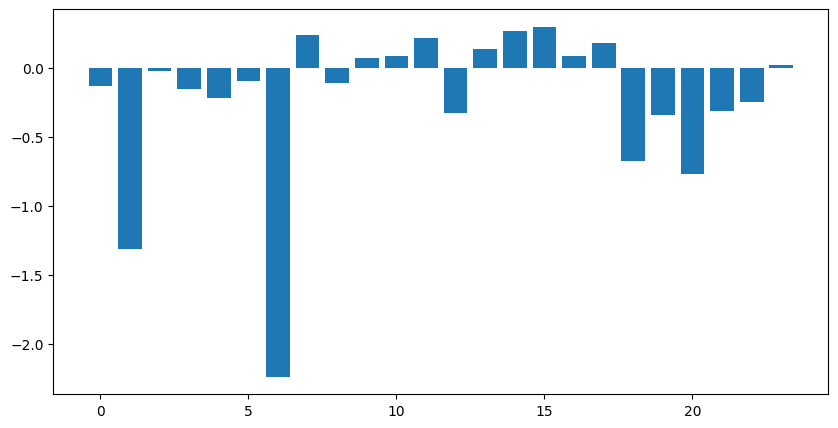

In [5]:
steering_vector_folder = 'steering_vectors/DA'

steering_loss.run(
    steering_vector_folder=steering_vector_folder,
    model_name="AI-Sweden-Models/gpt-sw3-356m",
    steering_lambda=10
)

## Plot steering vector PCAs

In [ ]:
steering_vector_folder = Path('steering_vectors/')

visualising_steering_vectors.run(
    steering_vector_paths_by_language={
        'en': lambda layer: steering_vector_folder / f'EN/combined_steering_vector_layer_{layer}_tensor.pt',
        'da': lambda layer: steering_vector_folder / f'DA/combined_steering_vector_layer_{layer}_tensor.pt',
        'sv': lambda layer: steering_vector_folder / f'SV/combined_steering_vector_layer_{layer}_tensor.pt',
        'nb': lambda layer: steering_vector_folder / f'NB/combined_steering_vector_layer_{layer}_tensor.pt',
        'is': lambda layer: steering_vector_folder / f'IS/combined_steering_vector_layer_{layer}_tensor.pt'
    },
    hidden_layers=24
)

## Bible study

In [ ]:
steering_vector_path = "steering_vectors/test_run_2/"
model_name = "AI-Sweden-Models/gpt-sw3-356m"
language1 = "da"
langauge2 = "en"
start_verse = 3
end_verse = 1000
lambda_search_space = [2,5,10,15]

create_bible_data.run(model_name,language1, steering_vector_path, lambda_search_space, start_verse,end_verse)


In [ ]:
path = "results/data/steering_data_bible/"
language_label = "__label__dan"
process_bible_data.run(path, language_label)

In [ ]:
visualize_bible_study.run(
    file_path='results/data/steering_data_bible/bible_data_combined.csv'
)